## Data Collection

In [ ]:
import tweepy
import pandas as pd

client = tweepy.Client(wait_on_rate_limit = True, bearer_token='') #use your own bearer token

# Replace with your own search query
query = '#BBNaija -is:retweet lang:en'

end_time='2022-10-01T00:00:00.000Z'
start_time='2022-09-30T00:00:00.000Z'

tweet_list = []
for pg in tweepy.Paginator(
    client.search_recent_tweets, query=query, end_time=end_time, start_time=start_time,expansions= 'author_id',
    tweet_fields=['created_at','source','public_metrics'], 
    user_fields = ['location','username','verified'],
    max_results=100, limit=10): #enter your own limit value
    
    for tweet, user in zip(pg.data, pg.includes['users']):
    tweet_info = {
        'created_at': tweet.created_at,
        'text': tweet.text,
        'source': tweet.source,
        'id': tweet.id,
        'retweets': tweet.public_metrics['retweet_count'],
        'likes': tweet.public_metrics['like_count'],
        'username': user.username,
        'location': user.location,
        'verified': user.verified,
    }
    tweet_list.append(tweet_info)

# create dataframe from the extracted records
tweets_df = pd.DataFrame(tweet_list)
# save the dataframe to csv
tweets_df.to_csv('September_30.csv')


##### Combine all csv files

In [1]:
import os
import glob
import pandas as pd
os.chdir("C:/Users/user/Desktop/BBNaija")

In [2]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [3]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

The combined dataset can be found [here](https://drive.google.com/drive/folders/1vaSdff6o_zNg34WhQOtQJ9X1VRaxdLZW?usp=sharing)

## Data Cleaning

In [4]:
df = pd.read_csv('combined_csv.csv')

In [5]:
df.head()

,Unnamed: 0,created_at,text,source,id,retweets,likes,username,location,verified
0,0,2022-08-24 23:59:58+00:00,Chichi is looking for highlights? But na your ...,Twitter Web App,1562590573164314628,0,3,unbotheredtiwa,"Lagos, Nigeria",False
1,1,2022-08-24 23:59:58+00:00,What Are They Talking About Abeg? #BBNaija,Twitter for Android,1562590572157603840,0,0,one9jaadvocate,NaN,False
2,2,2022-08-24 23:59:57+00:00,Biggie please play this gossip video for chich...,Twitter for iPhone,1562590568550543360,2,16,Mummy_Chizzy,Africa,False
3,3,2022-08-24 23:59:56+00:00,"See the video,Chi Chi fear God now😩😩, see the ...",Twitter for iPhone,1562590564817571841,0,16,Ador_dami,"Lagos, Nigeria",False
4,4,2022-08-24 23:59:56+00:00,"From day one, Maky and Fina were never friend...",Twitter for iPhone,1562590564213673984,0,0,Honey_potty65,"Lagos, Nigeria",False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909290 entries, 0 to 1909289
Data columns (total 10 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   created_at  object
 2   text        object
 3   source      object
 4   id          int64 
 5   retweets    int64 
 6   likes       int64 
 7   username    object
 8   location    object
 9   verified    bool  
dtypes: bool(1), int64(4), object(5)
memory usage: 132.9+ MB


In [7]:
df.isnull().sum()

Unnamed: 0         0
created_at         0
text               0
source             0
id                 0
retweets           0
likes              0
username           0
location      898671
verified           0
dtype: int64

In [8]:
df.text.duplicated().sum()

79672

In [9]:
df.duplicated().sum()

561

In [10]:
df.drop_duplicates(inplace=True)

In [14]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = pd.to_datetime(df['created_at']).dt.date
df['weekday'] = pd.to_datetime(df['date']).dt.day_name()
df['time'] = pd.to_datetime(df['created_at']).dt.hour

In [15]:
df.drop(['Unnamed: 0', 'created_at'], 1, inplace=True)

## Data Preprocessing

In [16]:
import re

In [17]:
def cleanTxt(tweet):
    # remove user handle
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    # remove http links
    tweet = re.sub("http\S+", "", tweet)
    # remove bitly links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) 
    # remove [links]
    tweet = tweet.strip('[link]') 
    # remove digits and special characters
    tweet = re.sub("[^a-zA-Z]", " ", tweet)
    # remove additional spaces
    tweet = re.sub("\s+", " ", tweet)
    return tweet

df['text'] = df['text'].apply(cleanTxt)

df['text'].head()

0    Chichi is looking for highlights But na your f...
1             What Are They Talking About Abeg BBNaija
2    Biggie please play this gossip video for chich...
3    See the video Chi Chi fear God now see the way...
4    From day one Maky and Fina were never friends ...
Name: text, dtype: object

In [18]:
#Next we have to remove emoji from the Tweet data.
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

#Cleaning the text
df['text']= df['text'].apply(remove_emoji)

## Sentiment Analysis

In [19]:
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

import textblob
from textblob import TextBlob

**Polarity** refers to the strength of an opinion. It could be positive or negative.

**Subjectivity** refers to the degree to which a person is personally involved in an object. 

Read more on subjectivity and polarity in sentiment analysis [here](https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524) 

In [20]:
#Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Create a function to get Polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Now we create a new column for what we just did and add it to the Tweet_df dataframe
df['Subjectivity'] = df['text'].apply(getSubjectivity)
df['Polarity'] = df['text'].apply(getPolarity)

In [59]:
df.head()

,text,source,id,retweets,likes,username,location,verified,date,weekday,time,Subjectivity,Polarity,Sentiment,bbn_cast,weekday_num,num_day
0,Chichi is looking for highlights But na your f...,Twitter Web App,1562590573164314628,0,3,unbotheredtiwa,"Lagos, Nigeria",False,2022-08-24,Wednesday,23,0.541667,-0.291667,Negative,chichi chichi,24,4
1,What Are They Talking About Abeg BBNaija,Twitter for Android,1562590572157603840,0,0,one9jaadvocate,NaN,False,2022-08-24,Wednesday,23,0.000000,0.000000,Neutral,,24,4
2,Biggie please play this gossip video for chich...,Twitter for iPhone,1562590568550543360,2,16,Mummy_Chizzy,Africa,False,2022-08-24,Wednesday,23,0.000000,0.000000,Neutral,chichi amaka chomzy bella,24,4
3,See the video Chi Chi fear God now see the way...,Twitter for iPhone,1562590564817571841,0,16,Ador_dami,"Lagos, Nigeria",False,2022-08-24,Wednesday,23,0.000000,0.000000,Neutral,chomzy,24,4
4,From day one Maky and Fina were never friends ...,Twitter for iPhone,1562590564213673984,0,0,Honey_potty65,"Lagos, Nigeria",False,2022-08-24,Wednesday,23,0.364583,-0.031250,Negative,,24,4


In [22]:
def getSentiment(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"
    
df['Sentiment']=df['Polarity'].apply(getSentiment)

In [23]:
df.Sentiment.value_counts()

Neutral     893585
Positive    691715
Negative    323429
Name: Sentiment, dtype: int64

In [60]:
df.to_csv('clean.csv', index=False)

## Data Visualization

In [25]:
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [26]:
house_mates = ['khalid','modella','pharmsavi','chichi','eloswag','giddyfia',
 'ilebaye','kess','deji','diana','dotun','doyin','beauty','chomzy',
 'cyph','christy','amaka','allysyn','sheggz','phyna','hermes',
 'groovy','daniella','bryann','bella','adekunle','rachel','chizzy']

In [27]:
def get_cast(tweet):
    tweet = tweet.lower() 
    tweet_tokens = word_tokenize(tweet)
    bbn_cast = [cast for cast in tweet_tokens if cast in house_mates] 
    return " ".join(bbn_cast)

In [28]:
df['bbn_cast'] = df['text'].apply(get_cast)

In [29]:
from collections import Counter

cast_bbn = df['bbn_cast'].tolist()
cast = []
for item in cast_bbn:
    item = item.split()
    for i in item:
        cast.append(i)

counts = Counter(cast)
cast_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
cast_df.columns = ['BBN_cast', 'Count']

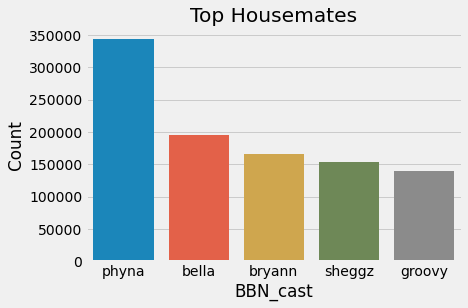

In [31]:
plt.title("Top Housemates")
sns.barplot(x='BBN_cast', y='Count', data = cast_df.nlargest(5, 'Count'))
plt.show()

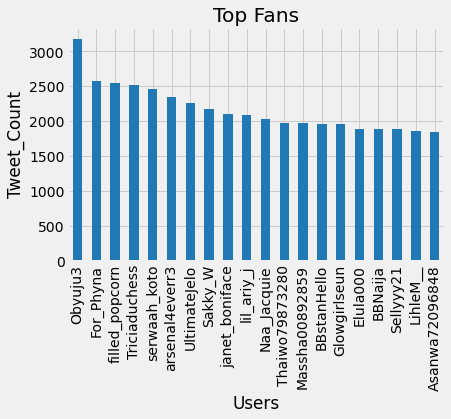

In [32]:
plt.title("Top Fans")
plt.xlabel("Users")
plt.ylabel("Tweet_Count")
df["username"].value_counts()[:20].plot(kind="bar", color="#2078B4")
plt.show()

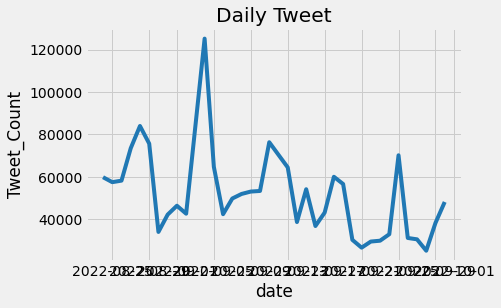

In [33]:
plt.title("Daily Tweet")
plt.xlabel("date")
plt.ylabel("Tweet_Count")
df["date"].value_counts().plot(kind="line", color="#2078B4")
plt.show()

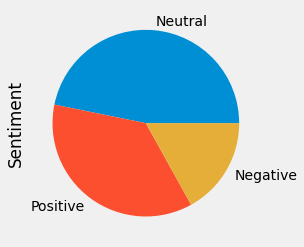

In [34]:
df["Sentiment"].value_counts().plot(kind="pie")
plt.show()

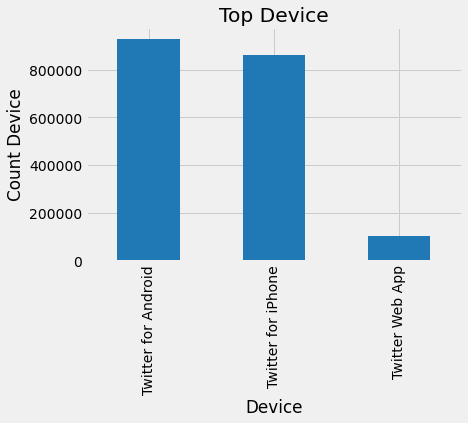

In [35]:
#Location of where the tweet is coming from
plt.title("Top Device")
plt.xlabel("Device")
plt.ylabel("Count Device")
df["source"].value_counts()[:3].plot(kind="bar", color="#2078B4")
plt.show()

In [36]:
stopwords = STOPWORDS
print(stopwords)

{'were', 'these', "how's", 'since', 'all', 'me', "when's", 'you', 'from', "wouldn't", 'until', "you're", "they're", 'your', 'am', 'no', 'for', 'as', "hasn't", 'other', 'there', "what's", 'else', "didn't", 'hers', 'would', 'theirs', 'ourselves', 'to', "couldn't", "doesn't", "it's", 'or', 'a', "they'd", "they've", "they'll", 'by', "can't", 'but', "haven't", 'at', "you'll", "won't", 'itself', 'get', "here's", 'his', 'how', 'we', 'on', 'if', 'under', "we're", 'only', "you've", 'ever', 'not', 'nor', "let's", 'same', 'yourself', 'her', 'after', "you'd", "we'll", 'herself', 'which', 'who', "i've", 'while', 'with', 'then', "wasn't", 'off', 'do', 'out', 'could', 'both', 'further', 'cannot', 'been', "he'll", 'was', 'just', "she's", 'few', 'here', 'being', 'what', 'too', "he's", 'below', 'down', "shan't", "she'd", 'where', 'and', "weren't", 'that', 'should', 'in', 'such', 'most', 'once', "shouldn't", 'some', 'therefore', 'yours', 'when', "we'd", 'has', 'through', "we've", "where's", 'they', 'howe

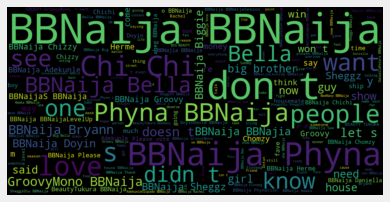

In [62]:
Tweet_Word = ' '.join( [twts for twts in df['text']] ) #To join all tweet
wc = WordCloud(
        background_color = "black",
        #stopwords = stopwords,
        height = 500,
        width = 1000,
        random_state = 42,
        max_font_size = 120
)
wc.generate(Tweet_Word)

plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()


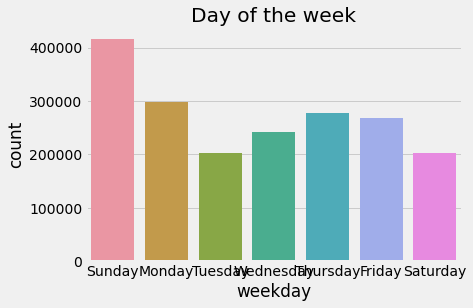

In [38]:
#Location of where the tweet is coming from
plt.title("Day of the week")
plt.xlabel("Weekday")
plt.ylabel("Count of tweet")
sns.countplot(x='weekday', order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], data=df)
plt.show()

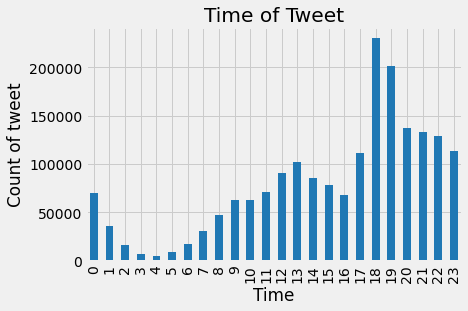

In [39]:
plt.title("Time of Tweet")
plt.xlabel("Time")
plt.ylabel("Count of tweet")
df["time"].value_counts().sort_index().plot(kind="bar", color="#2078B4")
plt.show()

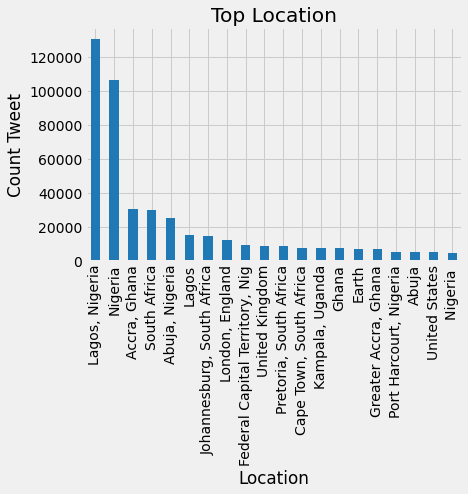

In [40]:
#Location of where the tweet is coming from
plt.title("Top Location")
plt.xlabel("Location")
plt.ylabel("Count Tweet")
df["location"].value_counts()[:20].plot(kind="bar", color="#2078B4")
plt.show()

In [55]:
#Tweet with the highest number of likes
df.sort_values('likes', ascending=False)

,text,source,id,retweets,likes,username,location,verified,date,weekday,time,Subjectivity,Polarity,Sentiment,bbn_cast
1419763,Thank you all for the support it was a good ru...,Twitter for iPhone,1571572640313212929,1457,23521,dotunoloniyo,"Lagos, Nigeria",False,2022-09-18,Sunday,18,0.550000,0.600000,Positive,
667664,It was seconds to leave Biggie s house but a l...,Twitter for iPhone,1566490989040226309,1317,19968,Mestar_Nova,NaN,False,2022-09-04,Sunday,18,0.727273,0.068182,Positive,
604832,It was seconds to leave Biggie s house but a l...,Twitter for iPhone,1566490989040226309,1317,19964,Mestar_Nova,NaN,False,2022-09-04,Sunday,18,0.727273,0.068182,Positive,
1745922,FAMILY MEANS NO ONE GETS LEFT BEHIND I m so em...,Twitter for iPhone,1574452800335101953,2234,18977,groovymono,"Lagos, Nigeria",False,2022-09-26,Monday,17,0.497143,0.077143,Positive,
1590641,The darker the berry BBNaija Allysyn,Twitter for Android,1572980392629620736,1028,16617,spiceny,Nigeria,False,2022-09-22,Thursday,16,0.000000,0.000000,Neutral,allysyn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313916,Louderrrrrrrr please bbnaija,Twitter for iPhone,1570227682687832070,0,0,Adabekeeblog,My mother’s house,False,2022-09-15,Thursday,1,0.000000,0.000000,Neutral,
721067,We go hard for big baby bryannnn Herm s don en...,Twitter for iPhone,1566864037241044995,0,0,Herladyisha,"Abuja, Nigeria",False,2022-09-05,Monday,19,0.358333,-0.152778,Negative,
721066,So all of the trenches are up BBNaija,Twitter for iPhone,1566864037480120320,0,0,mphoramz3,NaN,False,2022-09-05,Monday,19,0.000000,0.000000,Neutral,
301399,big bra omo is lk the hus dey call me for oo ...,Twitter for Android,1563920052071632899,0,0,collinaB_yor,"Edo, Nigeria",False,2022-08-28,Sunday,16,0.100000,0.000000,Neutral,
